In [1]:
import numpy as np
import pandas as pd
import math
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.decomposition import PCA
from scipy.stats import rankdata, norm, gaussian_kde
import matplotlib.pyplot as plt
from random import randrange

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
filename = "real_world_data/airline_dataset.csv"
data = pd.read_csv(filename)
df = pd.DataFrame(data)
df.head()

,Unnamed: 0,Airline,Flight,Time,Length,Delay
0,0,b'CO',269.0,15.0,205.0,1
1,1,b'US',1558.0,15.0,222.0,1
2,2,b'AA',2400.0,20.0,165.0,1
3,3,b'AA',2466.0,20.0,195.0,1
4,4,b'AS',108.0,30.0,202.0,0


In [3]:
train = df.iloc[:179794,:]
test = df.iloc[179794:,:]

ohe = OneHotEncoder()

X_train_num = train.drop(columns=["Airline", "Delay", "Unnamed: 0"])
X_train_cat = train[["Airline"]]
X_train_cat = ohe.fit_transform(X_train_cat).toarray()
X_train = np.concatenate([X_train_cat, X_train_num], axis=1)
X_test_num = test.drop(columns=["Airline", "Delay", "Unnamed: 0"])
X_test_cat = test[["Airline"]]
X_test_cat = ohe.transform(X_test_cat).toarray()
X_test = np.concatenate([X_test_cat, X_test_num], axis=1)

y_train = train[["Delay"]]
y_test = test[["Delay"]]

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train.head()

(179794, 21)
(359589, 21)
(179794, 1)
(359589, 1)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034306,0.003499,0.312977
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.199309,0.003499,0.338931
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307092,0.006998,0.251908
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.315540,0.006998,0.297710
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013697,0.013996,0.308397


111794


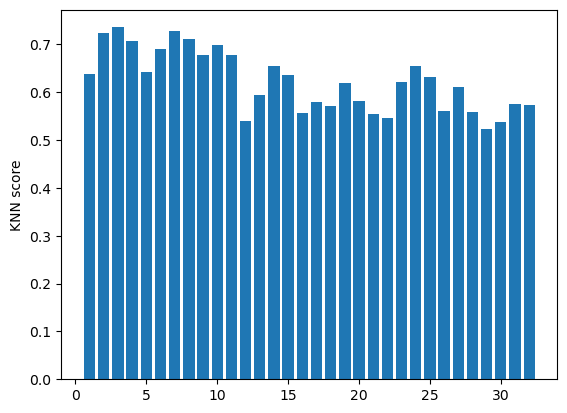

In [4]:
# Check for overfitting by employing time-based splitting; comparing random forest with kNN

# Remove 4 last batches from the training set
timesplit_test_start = 179794 - 4 * 17000
print(timesplit_test_start)

timesplit_train = df.iloc[:timesplit_test_start,:]
timesplit_test = df.iloc[timesplit_test_start:,:]

timesplit_ohe = OneHotEncoder()

timesplit_X_train_num = timesplit_train.drop(columns=["Airline", "Delay", "Unnamed: 0"])
timesplit_X_train_cat = timesplit_train[["Airline"]]
timesplit_X_train_cat = timesplit_ohe.fit_transform(timesplit_X_train_cat).toarray()
timesplit_X_train = np.concatenate([timesplit_X_train_cat, timesplit_X_train_num], axis=1)
timesplit_X_test_num = timesplit_test.drop(columns=["Airline", "Delay", "Unnamed: 0"])
timesplit_X_test_cat = timesplit_test[["Airline"]]
timesplit_X_test_cat = timesplit_ohe.transform(timesplit_X_test_cat).toarray()
timesplit_X_test = np.concatenate([timesplit_X_test_cat, timesplit_X_test_num], axis=1)

timesplit_y_train = timesplit_train[["Delay"]]
timesplit_y_test = timesplit_test[["Delay"]]

timesplit_scaler = MinMaxScaler()

timesplit_X_train = pd.DataFrame(timesplit_scaler.fit_transform(timesplit_X_train))
timesplit_X_test = pd.DataFrame(timesplit_scaler.transform(timesplit_X_test))


timesplit_X_test_batches = np.array_split(timesplit_X_train, 6)
timesplit_y_test_batches = np.array_split(timesplit_y_train, 6)

timesplit_i = 0
while timesplit_i < len(timesplit_X_test):
    new_i = timesplit_i + 17000
    if new_i > len(timesplit_X_test):
        new_i = len(timesplit_X_test)
    timesplit_X_test_batches.append(timesplit_X_test[timesplit_i: new_i])
    timesplit_y_test_batches.append(timesplit_y_test[timesplit_i: new_i])
    timesplit_i = new_i

expected_accs = []

timesplit_knn_accs = []
# timesplit_rf_accs = []

timesplit_model_knn = KNeighborsClassifier(n_neighbors=2066)
timesplit_model_knn.fit(timesplit_X_train, timesplit_y_train.values.ravel())

# timesplit_model_rf = RandomForestClassifier()
# timesplit_model_rf.fit(timesplit_X_train, timesplit_y_train.values.ravel())

for batch in range(len(timesplit_X_test_batches)):
    knn_batch_score = timesplit_model_knn.score(timesplit_X_test_batches[batch], timesplit_y_test_batches[batch])
#     print('\n', knn_batch_score)
    timesplit_knn_accs.append(knn_batch_score)
#     rf_batch_score = timesplit_model_rf.score(timesplit_X_test_batches[batch], timesplit_y_test_batches[batch])
#     print('\n', rf_batch_score)
#     timesplit_rf_accs.append(rf_batch_score)
    if batch < 4:
        expected_accs.append(knn_batch_score)
    
timesplit_x_range = np.arange(1, len(timesplit_X_test_batches) + 1)

plt.bar(timesplit_x_range, timesplit_knn_accs)
plt.ylabel("KNN score")
plt.show()

# plt.bar(timesplit_x_range, timesplit_rf_accs)
# plt.ylabel("RF score")
# plt.show()

In [5]:
X_test_batches = []
y_test_batches = []

i = 0
while i < len(X_test):
    new_i = i + 17000
    if new_i > len(X_test):
        new_i = len(X_test)
    X_test_batches.append(X_test[i: new_i])
    y_test_batches.append(y_test[i: new_i])
    i = new_i

print(len(X_test_batches))
print(X_test_batches[0].shape)
print(y_test_batches[0].shape)
print(X_test_batches[-1].shape)
print(y_test_batches[-1].shape)

22
(17000, 21)
(17000, 1)
(2589, 21)
(2589, 1)


In [6]:
accs = []
drifts = []
threshold = np.mean(expected_accs) - np.std(expected_accs)

model_knn = KNeighborsClassifier(n_neighbors=2066)
model_knn.fit(X_train, y_train.values.ravel())
for batch in range(len(X_test_batches)):
    batch_score = model_knn.score(X_test_batches[batch], y_test_batches[batch])
    print('\n', batch_score)
    if batch_score < threshold:
        print("drift in batch", batch + 1)
        drifts.append(batch + 1)
    accs.append(batch_score)
    
print(drifts)


 0.6770588235294117

 0.5417058823529411
drift in batch 2

 0.5935294117647059
drift in batch 3

 0.6555882352941177
drift in batch 4

 0.636235294117647
drift in batch 5

 0.5567647058823529
drift in batch 6

 0.5808823529411765
drift in batch 7

 0.5718823529411765
drift in batch 8

 0.6200588235294118
drift in batch 9

 0.5822941176470589
drift in batch 10

 0.5562941176470588
drift in batch 11

 0.5475882352941176
drift in batch 12

 0.623
drift in batch 13

 0.6551764705882352
drift in batch 14

 0.6313529411764706
drift in batch 15

 0.5631176470588235
drift in batch 16

 0.6124705882352941
drift in batch 17

 0.5592941176470588
drift in batch 18

 0.5250588235294118
drift in batch 19

 0.5390588235294118
drift in batch 20

 0.5758823529411765
drift in batch 21

 0.5739667825415218
drift in batch 22
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


0.6631834285573399


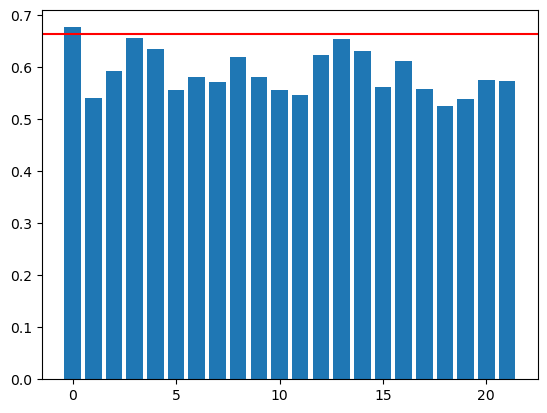

In [7]:
print(threshold)
plt.bar(range(0, len(X_test_batches)), accs)
plt.axhline(y=threshold, color='r', linestyle='-')
plt.show()